Import libraries

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Set up notebook environment
%matplotlib inline
sns.set_style("whitegrid")

1. Data Loading & Preprocessing

In [2]:
# Load dataset
file_path = 'D:/College/Projects/Phishing_Detection/phishing-detection-backend/app/data/Phishing_URL.csv'
data = pd.read_csv(file_path)

# Inspect dataset
print("Dataset preview:")
display(data.head())

# Check for missing values
print("Missing values:", data.isnull().sum().sum())

# Separate features and labels
X = data.drop(columns=['Index', 'class'])
y = data['class']

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

Dataset preview:


,Index,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,...,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport,class
0,0,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
1,1,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
2,2,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
3,3,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1
4,4,-1,0,-1,1,-1,-1,1,1,-1,...,1,1,1,1,1,-1,1,-1,-1,1


Missing values: 0


2. Exploratory Data Analysis (EDA)

Dataset description:


,UsingIP,LongURL,ShortURL,Symbol@,Redirecting//,PrefixSuffix-,SubDomains,HTTPS,DomainRegLen,Favicon,...,DisableRightClick,UsingPopupWindow,IframeRedirection,AgeofDomain,DNSRecording,WebsiteTraffic,PageRank,GoogleIndex,LinksPointingToPage,StatsReport
count,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,...,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000,11054.000000
mean,0.313914,-0.633345,0.738737,0.700561,0.741632,-0.734938,0.064049,0.251040,-0.336711,0.628551,...,0.913877,0.613353,0.816899,0.061335,0.377239,0.287407,-0.483626,0.721549,0.343948,0.719739
std,0.949495,0.765973,0.674024,0.713625,0.670837,0.678165,0.817492,0.911856,0.941651,0.777804,...,0.406009,0.789845,0.576807,0.998162,0.926158,0.827680,0.875314,0.692395,0.569936,0.694276
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000
50%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000
75%,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


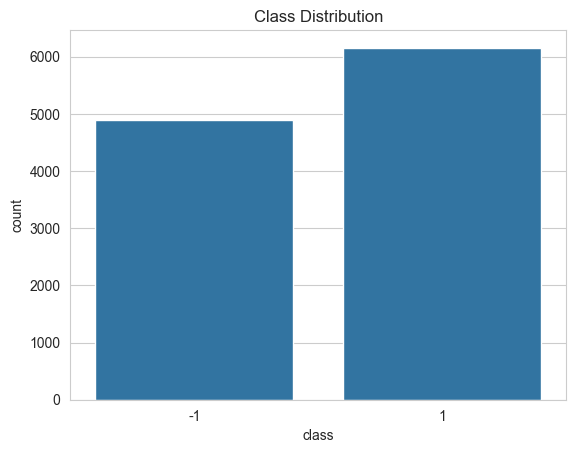

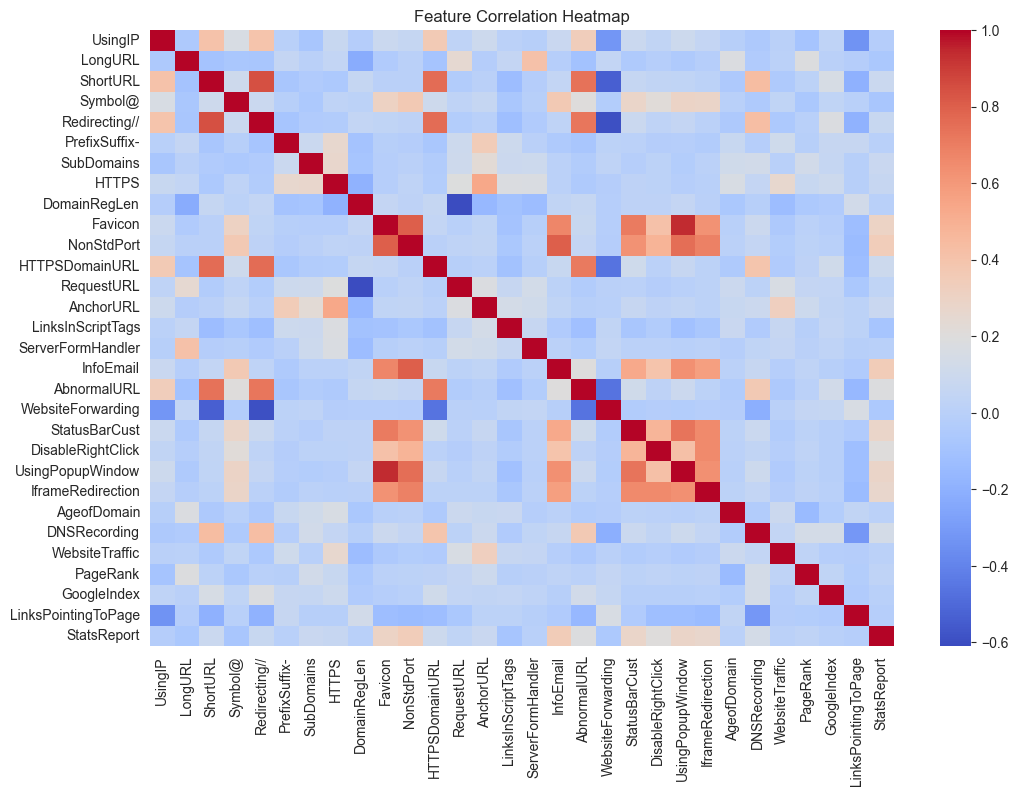

In [3]:
# Summary statistics
print("Dataset description:")
display(X.describe())

# Visualize class distribution
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

3. XGBoost Model Development

C:\Users\Archit Mahule\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:43:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Accuracy: 0.9696969696969697
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       976
           1       0.96      0.98      0.97      1235

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



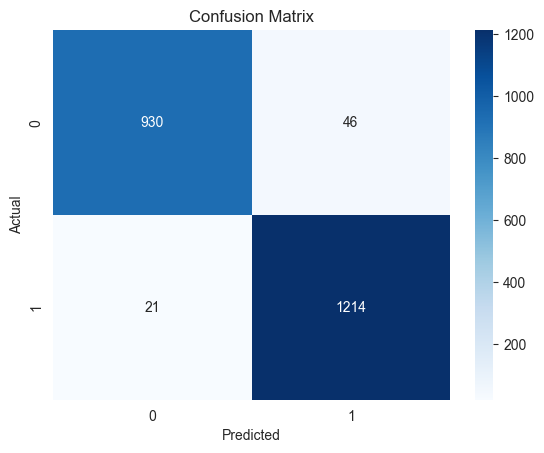

XGBoost model saved.


In [4]:
# Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost Model
y_pred = xgb_model.predict(X_test)
print("XGBoost Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save XGBoost model
xgb_model.save_model('./saved/xgboost_model.json')
print("XGBoost model saved.")

4. Autoencoder Model Development

Epoch 1/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2001 - val_loss: 0.1131
Epoch 2/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0977 - val_loss: 0.0756
Epoch 3/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0699 - val_loss: 0.0609
Epoch 4/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0565 - val_loss: 0.0503
Epoch 5/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0471 - val_loss: 0.0421
Epoch 6/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0393 - val_loss: 0.0362
Epoch 7/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0335 - val_loss: 0.0320
Epoch 8/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0301 - val_loss: 0.0291
Epoch 9/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0269 - val_loss: 0.0269
Epoch 10/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0249 - val_loss: 0.0253
Epoch 11/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0236 - val_loss: 0.0241
Epoch 12/50
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

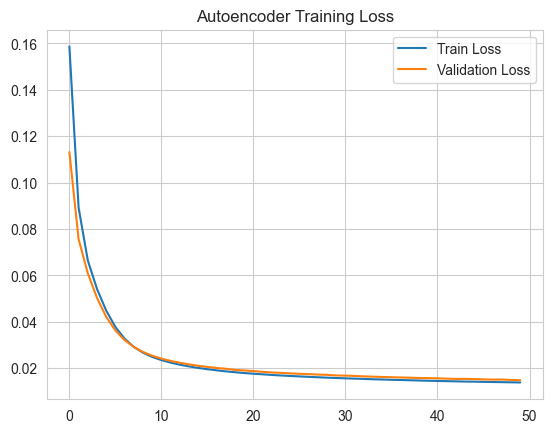

Autoencoder model saved.


In [5]:
# Normalize features for autoencoder
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Define autoencoder architecture
input_dim = X.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train autoencoder
history = autoencoder.fit(X_train_scaled, X_train_scaled, 
                          epochs=50, 
                          batch_size=32, 
                          shuffle=True, 
                          validation_data=(X_test_scaled, X_test_scaled))

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Autoencoder Training Loss")
plt.show()

# Save autoencoder model
autoencoder.save('./saved/url_autoencoder_model.h5')
print("Autoencoder model saved.")

5. Model Evaluation

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


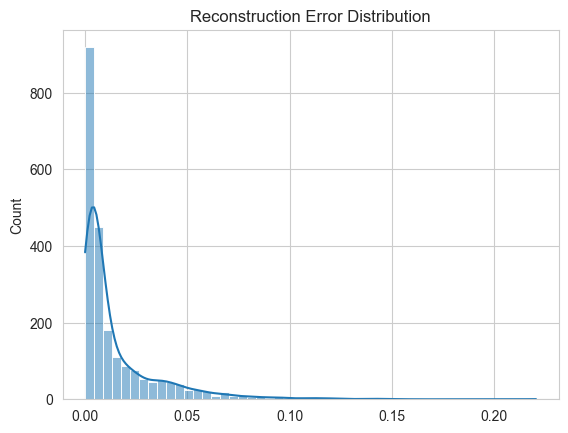

Anomaly Detection Threshold: 0.05720562114484537


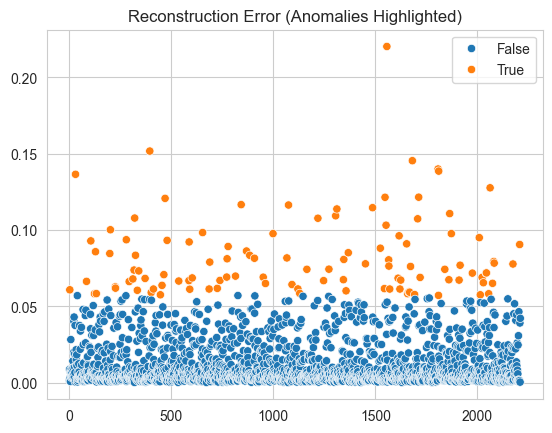

In [6]:
# Evaluate Autoencoder (Reconstruction Error)
reconstructed = autoencoder.predict(X_test_scaled)
reconstruction_error = np.mean(np.power(X_test_scaled - reconstructed, 2), axis=1)

# Plot reconstruction error
sns.histplot(reconstruction_error, bins=50, kde=True)
plt.title("Reconstruction Error Distribution")
plt.show()

# Threshold for anomaly detection
threshold = np.percentile(reconstruction_error, 95)
print("Anomaly Detection Threshold:", threshold)

# Visualize anomalies
anomalies = reconstruction_error > threshold
sns.scatterplot(x=range(len(reconstruction_error)), y=reconstruction_error, hue=anomalies)
plt.title("Reconstruction Error (Anomalies Highlighted)")
plt.show()